# Table of Contents
 <p>

In [1]:
from bs4 import BeautifulSoup
import urllib.request
import datetime as dt
import pandas as pd
from numpy  import array
import os
import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt

# more than one print of an unassigned variable
from IPython.core.interactiveshell import InteractiveShell;
InteractiveShell.ast_node_interactivity = "all";


In [2]:
pklData = "/users/John/projects/cryptoTracker/pklData"
priceDataDir ="/users/John/projects/cryptoTracker/historicalPriceData" 

In [3]:
def summaryData():
    url="https://coinmarketcap.com/all/views/all/"
    #print("Scraping: ", url)
    # download the table
    resp = urllib.request.urlopen(url)
    #print("getting data")
    soup = BeautifulSoup(resp, 'lxml')
    table = soup.find('table')
    
    # parse TABLE into LIST
    table_text=[]
    
    for tr in table.findAll('tr'):
        tds = tr.findAll('td')
        for td in tds:
            table_text.append(td.get_text())
            
    table_text = [w.replace('\n', '') for w in table_text]
            
    # parse LIST into DATAFRAME
    a = array(table_text)
    b = a.reshape(-1, 10)
    cols = ['#', 'Name', 'Symbol', 'Market Cap', 'Price', 'Circulating Supply', 'Volume (24h)', '% 1h', '% 24h', '% 7d']
    df = pd.DataFrame(b)
    df.columns = cols
    
    # make the date the index
    df = df.set_index('#')
    
    #for column in df:
    #    pd.to_numeric(column)
    
    # Remove ticker from name column
    df['Name'] = [e.replace(k, '') for e, k in zip(df.Name.astype('str'), df.Symbol.astype('str'))]
    df['Name'] = [y if x is '' else x for x, y in zip(df.Name, df.Symbol) ]
    
    return df

In [4]:
def loadData():
    os.chdir(pklData)
    '''Download and cache data'''
    
    fileName = 'coinList'
    cache_path = '{}/{}.pkl'.format(pklData, fileName)
    
    try:
        '''If data is already on disk, don't download it again'''
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        #print('Loaded {} from cache'.format(quandl_id))
        
    except (OSError, IOError) as e:
        print('Scraping data from coinmarketcap.com')
        df = summaryData()
        df.to_pickle(cache_path)
        print('Cached data at {}'.format(pklData) )
    
    os.chdir('..')
    return df

In [5]:
#coinData = loadData()

In [6]:
#coinList = coinData['Name'].tolist()
#coinList = [c.replace(' ', '-') for c in coinList]
#coinList = [c.lower() for c in coinList]
#coinList

In [7]:
def colToList(series):
    newList = series.tolist()
    newList = [c.replace(' ', '-') for c in newList]
    newList = [c.lower() for c in newList]
    return newList

In [105]:
def scrapePrice(coin, startDate = '20170601', endDate = dt.datetime.now().strftime("%Y%m%d") ):
    # get table from coinmarketcap.com
    coin = coin.lower()
    #.split('-', 1)[0]
    #print('coin url leader: ',coin)
    url="https://coinmarketcap.com/currencies/{}/historical-data/?start={}&end={}".format(coin,startDate,endDate)
    #print("Scraping: ", url)
    # download the table
    resp = urllib.request.urlopen(url)
    soup = BeautifulSoup(resp, 'lxml')
    table = soup.find('table')
    
    # parse result into a list
    table_text=[]
    
    for tr in table.findAll('tr'):
        tds = tr.findAll('td')
        for td in tds:
            table_text.append(td.get_text())
            
    # parse the list into a df
    a = array(table_text)
    b = a.reshape(-1, 7)
    cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
    df = pd.DataFrame(b)
    df.columns = cols
    
    # make the date the index
    df = df.set_index('Date')
    
    # make index a datetime
    df.index = pd.to_datetime(df.index)
    
    #for column in df:
    #    pd.to_numeric(column)
    return df

In [106]:
def scraperLoop(values, exceptionList):
    #values = values[n:]
    coins = {}
    i = 0    
    exceptionList = [w.replace(' ', '-') for w in exceptionList]
    exceptionList = [w.lower() for w in exceptionList]
        
    for coin in values:
        i += 1
        if i > 30:# 204:
            break
        if coin in exceptionList:
            print("{} skipping: {}".format(i, coin))
            pass
        else:
            cache_path = '{}/{}.pkl'.format(pklData, coin)
            try:
                '''If data is already on disk, don't download it again'''
                f = open(cache_path, 'rb')
                coins[coin] = pickle.load(f)   
                print('{}: Loaded {} from cache'.format(i, coin))
                
            except (OSError, IOError) as e:
                print("{} Scraping: {}".format(i, coin))
                coins[coin] = scrapePrice(coin)  
                coins[coin].to_csv("{}/{}.csv".format(priceDataDir, coin.lower()))
                    
                scrapePrice(coin).to_pickle(cache_path)
                #print('Cached data at {}'.format(pklData) )

    print ("Scraping complete")
    return coins

In [107]:
def one_col_from_each_df(dfDict, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    
    cols_as_dict = {}
    
    for key in dfDict:
        cols_as_dict[key] = dfDict[key][col]    
    
    return pd.DataFrame(cols_as_dict)

In [108]:
coinData = loadData()
#coinData.head()

In [109]:
coinList = colToList(coinData['Name'])
#coinList

In [110]:
exceptionList = ['bytecoin', 'Santiment Net...', 'basic-attenti...', 'byteball-bytes', \
                 'raiden-networ...', 'gnosis', '-Coin', 'streamr-coin', 'hares', 'metaverse-', \
                 'evain', 'ripio-credit-...', 'chain', 'iexec-', 'quantum-resis...', 'open-trading-...', \
                'cofound.it', 'wetrust', 'i/o-coin', 'lbry-credits', 'matchpool', 'ambrosus', 'cash', \
                 'safe-exchange...', 'russian-miner...', 'global-curren...', 'grid+', 'po.et']

coins = scraperLoop(coinList, exceptionList)

1: Loaded bitcoin from cache
2: Loaded ethereum from cache
3: Loaded bitcoin-cash from cache
4: Loaded ripple from cache
5: Loaded litecoin from cache
6: Loaded iota from cache
7: Loaded dash from cache
8: Loaded bitcoin-gold from cache
9: Loaded nem from cache
10: Loaded monero from cache
11: Loaded cardano from cache
12: Loaded eos from cache
13: Loaded ethereum-classic from cache
14: Loaded neo from cache
15: Loaded stellar from cache
16: Loaded bitconnect from cache
17: Loaded populous from cache
18: Loaded zcash from cache
19: Loaded waves from cache
20: Loaded qtum from cache
21: Loaded tron from cache
22: Loaded lisk from cache
23: Loaded omisego from cache
24: Loaded tether from cache
25: Loaded stratis from cache
26: Loaded ardor from cache
27: Loaded monacoin from cache
28: Loaded hshare from cache
29: Loaded nxt from cache
30: Loaded bitshares from cache
Scraping complete


In [111]:
marketCaps = one_col_from_each_df(coins, 'Market Cap')
marketCaps.to_csv("marketCaps.csv")

In [113]:
#marketCaps.tail()
#marketCaps.dtypes

In [114]:
for column in marketCaps:
    marketCaps[column] = marketCaps[column].str.replace(',', '')
    marketCaps[column] = pd.to_numeric( marketCaps[column], errors='coerce')

#marketCaps.dtypes
#marketCaps.tail()

Populating the interactive namespace from numpy and matplotlib


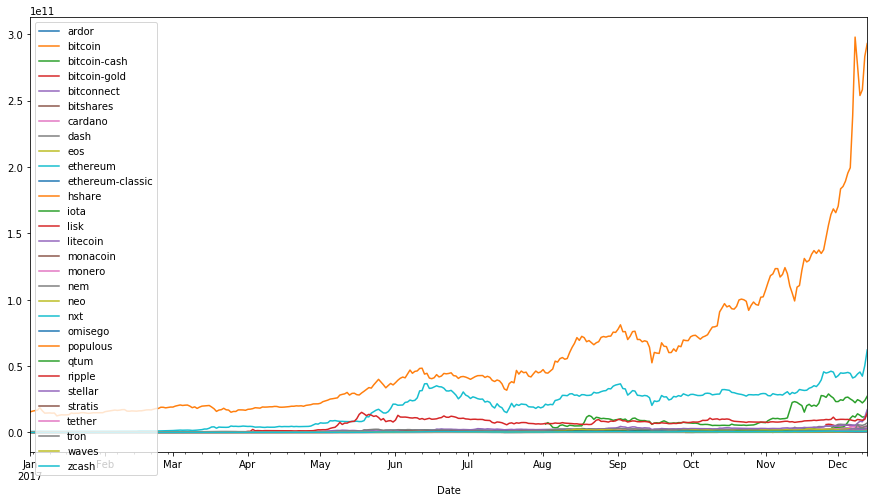

In [115]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)

marketCaps.plot(logy=False)